# Load Data  

In [1]:
import numpy as np
import pandas as pd
import random

from PIL import Image

import os
import glob

from tensorflow.keras.utils import to_categorical

2023-01-24 18:21:33.185018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:21:33.294689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 18:21:33.294707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 18:21:33.319630: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-24 18:21:33.940323: W tensorflow/stream_executor/platform/de

In [2]:
import matplotlib.pyplot as plt


In [3]:
categories = ["dick" , "nodick"]

In [4]:
%%time

data = []
target = []

for cat in categories:
    filelist = glob.glob('/mnt/h/dataset-part1/'+cat+ '/*.j*')
    target.extend(cat for _ in filelist)
    data.extend([np.array(Image.open(fname).resize((100,100))) for fname in filelist])



/home/enzo/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


CPU times: user 2min 46s, sys: 9.82 s, total: 2min 56s
Wall time: 3min 35s


In [6]:
for i in range(len(data)):
    if data[i].shape != (100,100,3):
        data.pop(i)
        target.pop(i)

In [7]:
data_array = np.stack(data,axis=0)

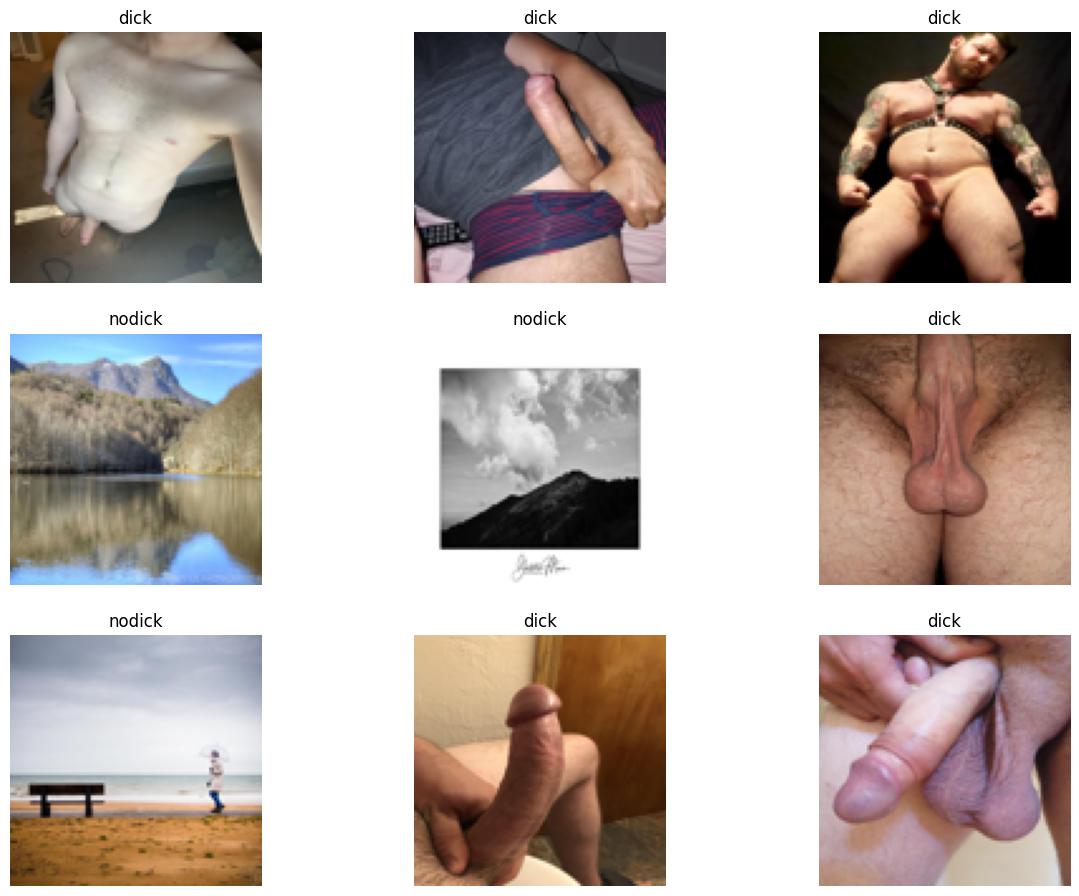

In [8]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4,4)

for line in range(0,3):
    for row in range(0,3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line,row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image])

# Data Splitting

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [10]:
encoder = LabelEncoder()
target = encoder.fit_transform(target)

In [11]:
X = data_array
y = target

X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=0.33)

In [12]:
X_test_norm = np.round((X_test/255),3).copy()
X_train_norm = np.round((X_train/255),3).copy()

In [13]:
X_train_norm.shape

(3830, 100, 100, 3)

In [14]:
X_train_norm = X_train_norm.reshape(-1,100, 100,3)
X_test_norm = X_test_norm.reshape(-1,100,100,3)

In [15]:
y_test_oh = to_categorical(y_test)
y_train_oh = to_categorical(y_train)

In [16]:
X_train_norm.shape

(3830, 100, 100, 3)

In [17]:
y_train_oh.shape

(3830, 2)

# Model Creation

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3) , activation="relu" , input_shape=(100,100 ,3) , padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100,activation='relu'))
    model.add(layers.Dense(50,activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(25,activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(2,activation='softmax'))
    
    return model

model= initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 80000)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               8000100   
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                      

In [27]:
es = EarlyStopping(patience = 10 ,restore_best_weights=True)

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
             metrics=['accuracy'])

history = model.fit(X_train_norm , y_train_oh,
                   batch_size=16,
                   epochs=1000,
                   validation_split=0.3,
                   callbacks=[es])

Epoch 1/1000
168/168 [==============================] - 9s 51ms/step - loss: 0.8198 - accuracy: 0.6934 - val_loss: 0.2725 - val_accuracy: 0.8999
Epoch 2/1000
168/168 [==============================] - 8s 48ms/step - loss: 0.3154 - accuracy: 0.8791 - val_loss: 0.2228 - val_accuracy: 0.9173
Epoch 3/1000
168/168 [==============================] - 9s 52ms/step - loss: 0.2334 - accuracy: 0.9168 - val_loss: 0.2128 - val_accuracy: 0.9173
Epoch 4/1000
168/168 [==============================] - 9s 51ms/step - loss: 0.1738 - accuracy: 0.9441 - val_loss: 0.2988 - val_accuracy: 0.8999
Epoch 5/1000
168/168 [==============================] - 9s 52ms/step - loss: 0.1186 - accuracy: 0.9537 - val_loss: 0.4328 - val_accuracy: 0.8782
Epoch 6/1000
168/168 [==============================] - 8s 50ms/step - loss: 0.0907 - accuracy: 0.9690 - val_loss: 0.3338 - val_accuracy: 0.9112
Epoch 7/1000
168/168 [==============================] - 8s 48ms/step - loss: 0.0669 - accuracy: 0.9761 - val_loss: 0.4246 - val_ac

In [22]:
from plot_keras_history import plot_history

(<Figure size 1000x500 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

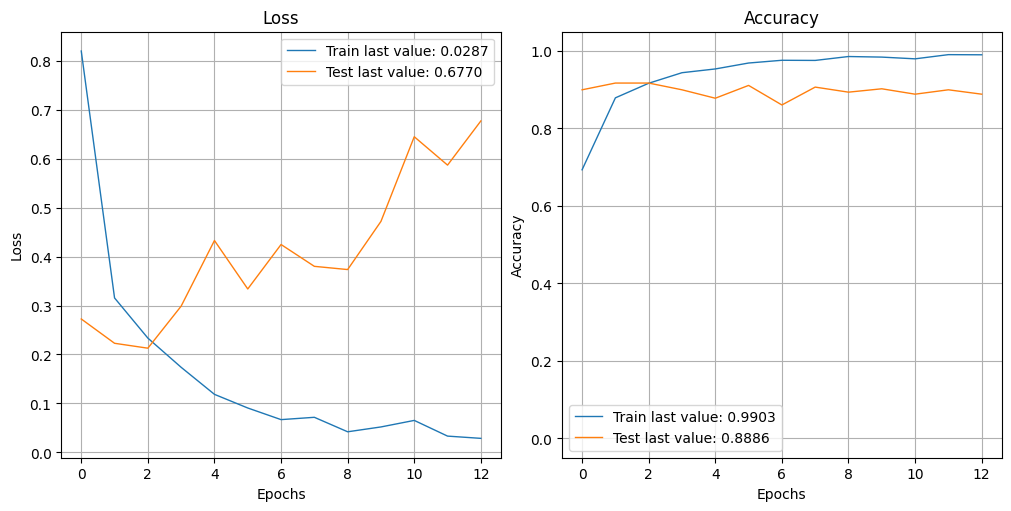

In [28]:
plot_history(history)

In [29]:
model.evaluate(X_test_norm,y_test_oh)

59/59 [==============================] - 1s 18ms/step - loss: 0.2047 - accuracy: 0.9269


[0.20472750067710876, 0.9268680214881897]

In [30]:
predictions = model.predict(X_test_norm)

59/59 [==============================] - 1s 20ms/step


# Evaluate and plot

Text(0.42, 0.98, 'Predited label for the displayed picture')

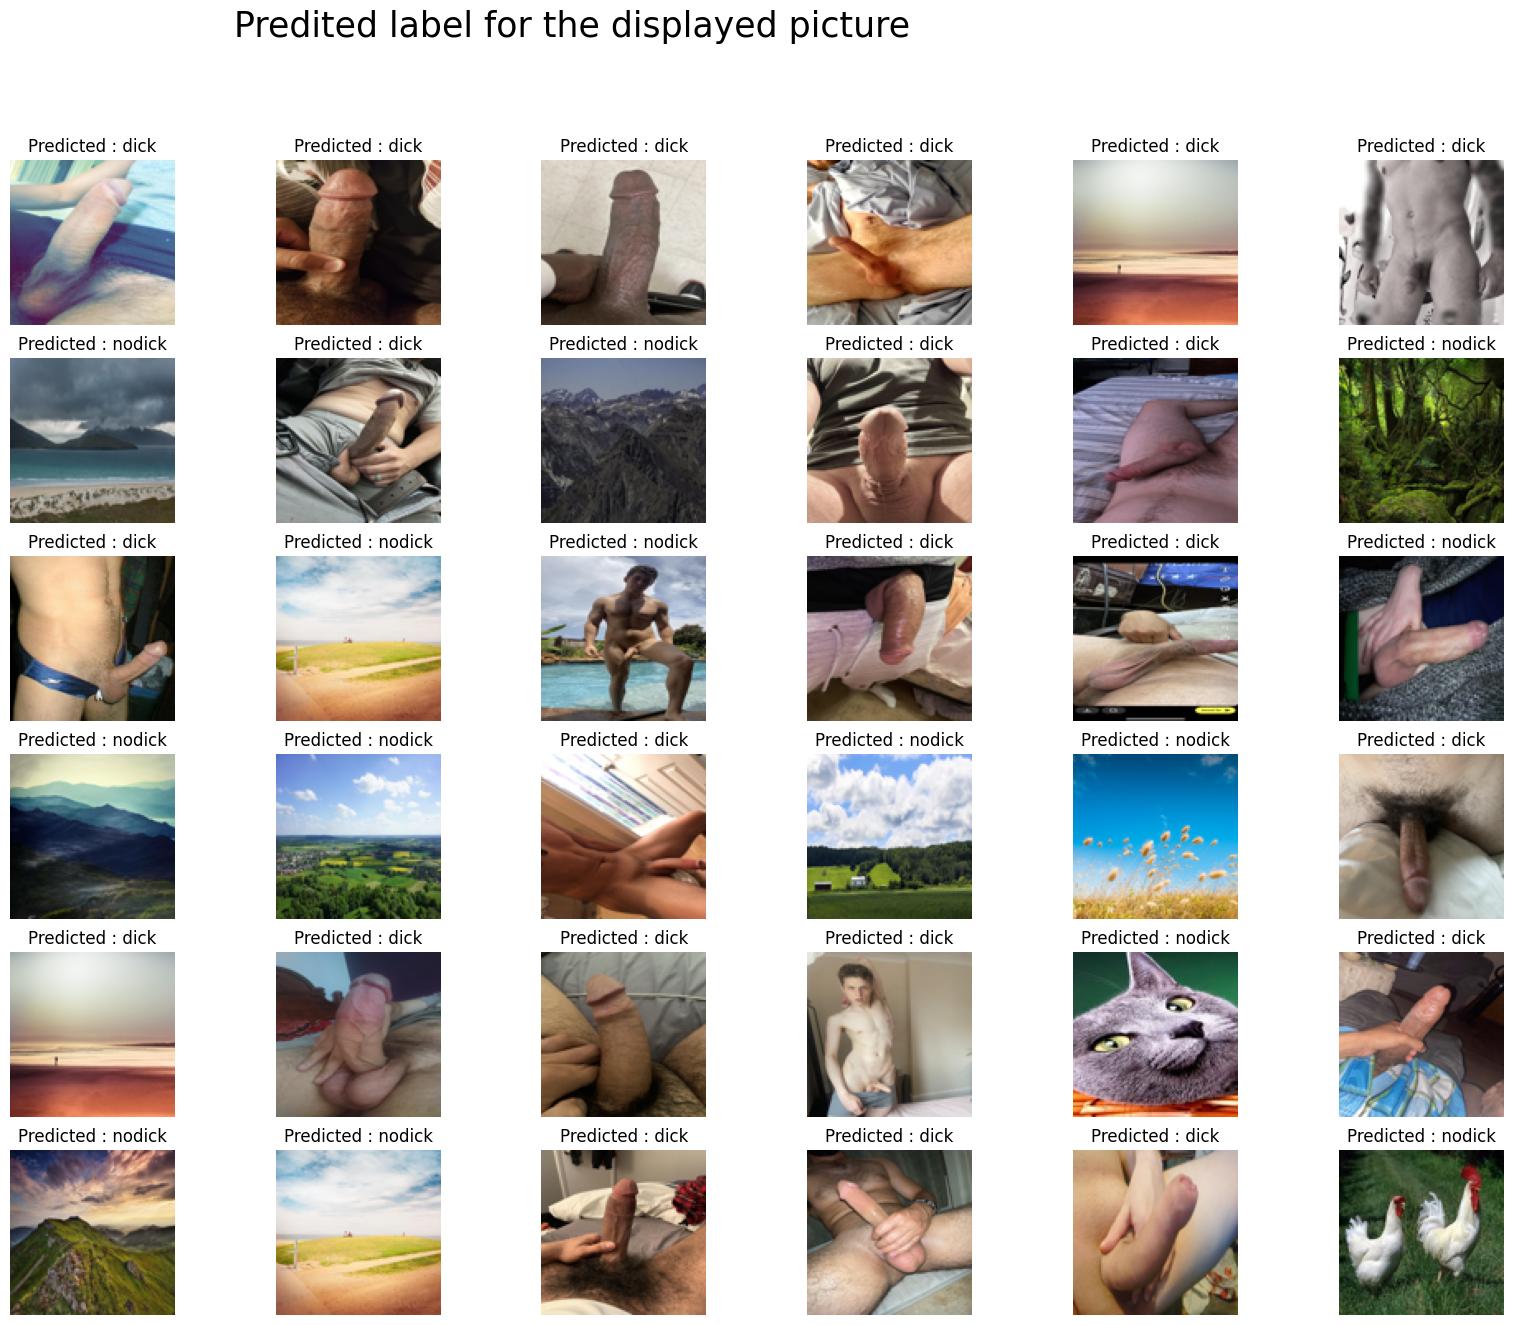

In [31]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(6,6)

for line in range(0,6):
    for row in range(0,6):
        num_image = random.randint(0, X_test_norm.shape[0])
        ax = fig.add_subplot(gs[line,row])
        ax.axis('off');
        ax.set_title("Predicted : " + categories[list(np.round(predictions[num_image])).index(1)])
        ax.imshow(X_test_norm[num_image])
fig.suptitle("Predited label for the displayed picture",fontsize = 25 , x= 0.42)